# What's this all about?

This came from an idea that I had when I was watching a lecture from Ian Goodfellow on adversarial attacks. An adversarial attack looks like this:

In [2]:
from IPython.display import Image
Image("img/adversarial_attack.png")
import matplotlib.pyplot as plt

With some carefully crafted noise, neural networks can be systematically fooled into making wildly incorrect predictions. This on its own is intriguing, but it was something else that inspired this project.

When talking about the use of adversarial attacks in practice, Goodfellow mentioned that there were a few ways of pulling it off. If you have full access to the model, you just backpropagate all the way back to the input of the network. If you can only run queries on the model, you can use synthetic gradients (though it takes longer) to generate attacks. Ok, sure - makes sense. But what if you don't have the ability to run multiple queries? What if you only have one chance at fooling a network you've never seen before?

Oddly enough, you can still generate an adversarial attack for a brand new network. The answer is surprisingly simple - you just use an adversarial example from another network. In the image above, you would probably be able to use this attack on many other networks that have been trained on the same dataset.

This fact made me believe that neural networks trained on the same dataset are learning the same function. It's a very complicated function that is parameterized by the dataset. But since it's just one function, that would explain why many different networks can be fooled by the same examples. Under this view, since a dataset completely defines a function that is learned by the network during training, there is an equivalence between a dataset and the final network state after training. Training is molding a network to take on the function defined by the dataset, and the reverse is adversarial training: creating a dataset from a function defined by the network.

This relationship between datasets and trained networks can be used to do some interesting things. The principal question: if networks are learning the same function after all, can you train networks to correctly classify images by training them to make the same mistakes as another trained network?

# Making a few models

In [3]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torchvision.models.resnet import ResNet, BasicBlock, Bottleneck
import torch.nn as nn

In [4]:
class SimpleDenseNet(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=128, output_dim=10, learning_rate=1e-2):
        super(SimpleDenseNet, self).__init__()
        self.l1 = nn.Linear(input_dim, hidden_dim)
        self.l2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.l1(x)
        x = F.relu(x)
        x = self.l2(x)
        x = F.relu(x)
        return x

In [5]:
class ConvNet(nn.Module):
    def __init__(self, input_dim=784, output_dim=10):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc = nn.Linear(20, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.max_pool2d(x, kernel_size=3)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, kernel_size=3)
        x = x.view(-1, 20)
        x = F.relu(x)
        x = self.fc(x)
        return x

In [6]:
class MNISTResNet(ResNet):
    def __init__(self):
        super(MNISTResNet, self).__init__(BasicBlock, [2, 2, 2, 2], num_classes=10) # Based on ResNet18
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=1, padding=3,bias=False)

In [7]:
class MultiLayerDenseNet(nn.Module):
    def __init__(self, input_dim=784, hidden_dims=None, output_dim=10):
        super(MultiLayerDenseNet, self).__init__()
        if hidden_dims is None:
            hidden_dims = [256, 128]
        layers = []
        curr = input_dim
        for hidden_dim in hidden_dims+[output_dim]:
            layers.append(nn.Linear(curr, hidden_dim))
            curr = hidden_dim
        self.layers = nn.ModuleList(layers)
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
            x = F.relu(x)
        return x

# Getting the dataset

In [8]:
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import os

In [9]:
mnist_train = torchvision.datasets.MNIST(root="./data", transform=transforms.ToTensor(), download=True)
mnist_test = torchvision.datasets.MNIST(root="./data", train=False, transform=transforms.ToTensor(), download=True)
# mnist_train.data = mnist_train.data.double()
# mnist_test_data = mnist_test.data.double()

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [10]:
mnist_train_loader = DataLoader(dataset=mnist_train, batch_size=32, shuffle=True)
mnist_test_loader = DataLoader(dataset=mnist_test, batch_size=32, shuffle=True)

# Set up training code

In [182]:
def train_model(model, train_loader, num_epochs=10, lr=0.001, conv_net=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    #optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    model = model.to(device)
    model.train()
    # train the model to convergence
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            # send to device
            if conv_net:
                images = images.reshape(-1, 1, 28, 28).to(device)
            else:
                images = images.reshape(-1, 28 * 28).to(device)
            # run model and calculate loss
            labels = labels.to(device)
            outputs = model.forward(images)
            loss = loss_function(outputs, labels)
            # calculate gradients and step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if not (i + 1) % 100:
                print('Epoch [{}/{}], Step[{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, len(train_loader), loss.item()))
        print("EPOCH {} COMPLETE".format(epoch + 1))

In [183]:
def test_model(model, test_loader, conv_net = False):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # test model
    model.to(device)
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            # send to device
            if conv_net:
                images = images.reshape(-1, 1, 28, 28).to(device)
            else:
                images = images.reshape(-1, 28 ** 2).to(device)
            labels = labels.to(device)
                        # run model
            outputs = model.forward(images)
            _, predictions = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predictions == labels).sum().item()
        print("Accuracy: {} %".format(100 * correct / total))

In [184]:
def save_model(model, model_name):
    dir = "./models/"
    torch.save(model.state_dict(), dir+model_name)

# Train a few models

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

## Simple Dense Nets

In [14]:
hidden_layer_sizes = [2048, 1024, 512, 256]
for hidden_layer_size in hidden_layer_sizes:
    print("Simple Dense Net: Hidden Layer Size "+str(hidden_layer_size))
    model = SimpleDenseNet(hidden_dim=hidden_layer_size)
    path = "./models/SimpleDense"+str(hidden_layer_size)
    if os.path.exists(path):
        checkpoint = torch.load(path)
        model.load_state_dict(checkpoint)
        print("Loaded model")
    train_model(model, mnist_train_loader, num_epochs=3, lr=0.001)
    test_model(model, mnist_test_loader)
    save_model(model, "SimpleDense"+str(hidden_layer_size))

In [13]:
#this is the best simple dense net
simple_dense_net = SimpleDenseNet(hidden_dim=512)
path = "./models/SimpleDense512"
if os.path.exists(path):
    checkpoint = torch.load(path)
    simple_dense_net.load_state_dict(checkpoint)
    print("Loaded Model")

Loaded Model


/usr/local/lib/python3.6/dist-packages/torch/cuda/__init__.py:125: UserWarning: 
Tesla T4 with CUDA capability sm_75 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_70.
If you want to use the Tesla T4 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


## Multi Layer Dense Net

In [14]:
hidden_layer_dimensions = (512, 256, 128)
multi_layer_dense_net = MultiLayerDenseNet(hidden_dims=list(hidden_layer_dimensions))
model_name = "MultiLayerDense"
for layer_dim in hidden_layer_dimensions:
    model_name += "_"+str(layer_dim)
path = "./models/" + model_name
if os.path.exists(path):
    checkpoint = torch.load(path)
    multi_layer_dense_net.load_state_dict(checkpoint)
    print("Loaded model")

Loaded model


In [17]:
train_model(model, mnist_train_loader, num_epochs=10, lr=3e-5)
test_model(model, mnist_test_loader)
save_model(model, model_name)

## Conv Net

In [15]:
conv_net = ConvNet()
model_name = "ConvNet"
path = "./models/" + model_name
if os.path.exists(path):
    checkpoint = torch.load(path)
    conv_net.load_state_dict(checkpoint)
    print("Loaded model")

Loaded model


In [ ]:
train_model(conv_net, mnist_train_loader, num_epochs=10, lr=0.003, conv_net=True)
test_model(conv_net, mnist_test_loader, conv_net=True)
save_model(conv_net, model_name)

## Res Net

In [16]:
res_net = MNISTResNet()
model_name = "MNISTResNet"
path = "./models/" + model_name
if os.path.exists(path):
    checkpoint = torch.load(path)
    res_net.load_state_dict(checkpoint)
    print("Loaded model")

Loaded model


In [ ]:
train_model(res_net, mnist_train_loader, num_epochs=5, lr=1e-4, conv_net=True)
test_model(res_net, mnist_test_loader, conv_net=True)
save_model(res_net, model_name)

# Setting up the adversarial attack

In [17]:
def create_incorrect_labels(labels, num_classes = 10):
    random_labels = torch.randint_like(labels, num_classes)
    diff = random_labels - labels == 0
    while any(diff):
        random_labels[diff] = torch.randint_like(random_labels[diff], num_classes)
        diff = random_labels - labels == 0
    return random_labels

In [155]:
def create_adversarial_dataset_from_model(model, X, Y, conv_net=False, conf=0.99):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    model.float()
    if conv_net:
        dataset = torch.empty(0, 1, 28, 28).to(device)
    else:
        dataset = torch.empty(0, 28*28).to(device)
    labels_to_return= torch.empty(0).to(device)
    iteration = 0
    batch_size = 1000
    for i in range(int(X.size(0)/batch_size)):
        samples_to_attack = X[i:i+batch_size].clone()
        labels = Y[i:i+batch_size].reshape(batch_size).to(device)
        if conv_net:
            samples_to_attack = samples_to_attack.reshape(batch_size, 1, 28, 28)
        else:
            samples_to_attack = samples_to_attack.reshape(batch_size, 28*28)
        x, indices = attack_samples(samples_to_attack, labels, model)
        dataset = torch.cat([dataset, x])
        labels_to_return = torch.cat([labels_to_return, labels[indices]])
        print(str(x.size(0)) + " samples added.")
        iteration+=1
        print(str(iteration) + " of " + str(X.size(0)//batch_size))
    return dataset, labels_to_return

In [146]:
def attack_samples(x, y, net, conf=0.99, step_size=0.02):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    x = x.to(device)
    y = y.to(device)
    net = net.to(device)
    net.float()
    x = x.float()
    y = y.long()
    x.requires_grad_()
    c = 0
    net.eval()
    optimizer = torch.optim.Adam([x,], lr=step_size, amsgrad=True)
    loss_func = nn.CrossEntropyLoss()
    i = 0
    while i < 400:
        y_hat = net(x)
        loss = loss_func(y_hat, y)
        vals = torch.softmax(y_hat, 1).gather(1, y.reshape(-1, 1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
          x.clamp_(0, 1).float()
        i+=1
    x.requires_grad_(False)
    good_indices = (vals >= conf).reshape(-1).to(device)
    return x[good_indices, :], good_indices

# Attacking datasets

In [18]:
mnist_full_X = mnist_train.data.float().reshape(-1, 28*28).clone()/255.

In [19]:
mnist_full_Y = mnist_train.targets

## Simple Dense

In [21]:
mnist_incorrect_Y = create_incorrect_labels(mnist_full_Y)

In [123]:
x, y = mnist_full_X[:1000], mnist_incorrect_Y[:1000]

In [ ]:
dataset = create_adversarial_dataset_from_model(simple_dense_net, mnist_full_X, mnist_incorrect_Y)

In [170]:
dataset_path = "./data/mnist_attacked_simple_dense"
torch.save(dataset, dataset_path)

## Conv Net

In [149]:
mnist_incorrect_Y = create_incorrect_labels(mnist_full_Y)

In [ ]:
dataset = create_adversarial_dataset_from_model(conv_net, mnist_full_X, mnist_incorrect_Y, conv_net=True)

In [157]:
dataset_path = "./data/mnist_attacked_conv_net"
torch.save(dataset, dataset_path)

## ResNet

In [158]:
mnist_incorrect_Y = create_incorrect_labels(mnist_full_Y)

In [ ]:
dataset = create_adversarial_dataset_from_model(conv_net, mnist_full_X, mnist_incorrect_Y, conv_net=True)

In [160]:
dataset_path = "./data/mnist_attacked_res_net"
torch.save(dataset, dataset_path)

## Multilayer Dense

In [161]:
mnist_incorrect_Y = create_incorrect_labels(mnist_full_Y)

In [ ]:
dataset = create_adversarial_dataset_from_model(multi_layer_dense_net, mnist_full_X, mnist_incorrect_Y)

In [164]:
dataset_path = "./data/mnist_attacked_multilayer_dense"
torch.save(dataset, dataset_path)

## Attacking a completely random dataset

In [166]:
random_dataset = torch.rand_like(mnist_full_X)
random_labels = torch.randint_like(mnist_full_Y, 10)

In [ ]:
dataset = create_adversarial_dataset_from_model(simple_dense_net, random_dataset, random_labels)

In [168]:
dataset_path = "./data/random_attacked_simple_dense"
torch.save(dataset, dataset_path)

## Visualizing the attacked datasets

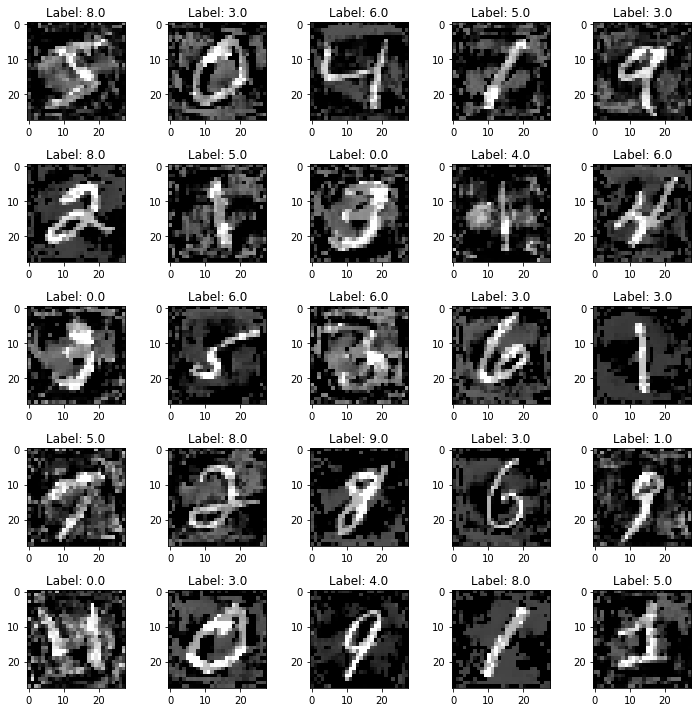

In [180]:
images, labels = dataset
images, labels = images.cpu(), labels.cpu()
r = 5
c = 5
fig, axes = plt.subplots(r, c, figsize=(2*c,2*r))
for i in range(r*c):
    ax = axes[i//c, i%c]
    ax.imshow(images[i].reshape(28, 28), cmap='gray')
    ax.set_title('Label: {}'.format(labels[i]))
plt.tight_layout()
plt.show()

# Training models on attacked datasets

### Dataset from tensor

In [188]:
from torch.utils.data import TensorDataset

In [225]:
datasets = {}
dataset_names  = ["mnist_attacked_conv_net", "mnist_attacked_multilayer_dense", "mnist_attacked_res_net", "mnist_attacked_simple_dense", "random_attacked_simple_dense"]
for dataset_name in dataset_names:
    X, Y = torch.load("./data/"+dataset_name)
    attacked_dataset = TensorDataset(X, Y.long())
    attacked_dataset_loader = DataLoader(attacked_dataset, batch_size=32, shuffle=True)
    datasets[dataset_name] = attacked_dataset_loader

## Training on attacked datasets

###Dense nets

In [ ]:
dense_nets = []
for dataset in datasets.values():
    model = SimpleDenseNet(hidden_dim=512)
    dense_nets.append(model)
    train_model(model, dataset, num_epochs=10, lr=1e-4)

### Multilayer Dense Nets

In [ ]:
multilayer_dense_nets = []
for dataset in datasets.values():
    model = MultiLayerDenseNet(hidden_dims=[512, 256, 256])
    multilayer_dense_nets.append(model)
    train_model(model, dataset, num_epochs=6, lr=0.00003)

### Conv Nets

In [ ]:
conv_nets = []
for dataset in datasets.values():
    model = ConvNet()
    conv_nets.append(model)
    train_model(model, dataset, num_epochs=6, lr=0.001, conv_net=True)

### Res Nets

In [ ]:
res_nets = []
for dataset in datasets.values():
    model = MNISTResNet()
    res_nets.append(model)
    train_model(model, dataset, num_epochs=3, lr=0.0001, conv_net=True)

## Now here's the head scratcher

In [272]:
print("Simple Dense Net Performance")
for model in dense_nets:
    test_model(model, mnist_test_loader)

Simple Dense Net Performance
Accuracy: 10.82 %
Accuracy: 51.17 %
Accuracy: 12.4 %
Accuracy: 53.06 %
Accuracy: 33.83 %


In [273]:
print("MultiLayer Dense Net Performance")
for model in multilayer_dense_nets:
    test_model(model, mnist_test_loader)

MultiLayer Dense Net Performance
Accuracy: 11.42 %
Accuracy: 51.62 %
Accuracy: 11.0 %
Accuracy: 33.03 %
Accuracy: 26.27 %


In [275]:
print("Conv Net Performance")
for model in conv_nets:
    test_model(model, mnist_test_loader, conv_net=True)

Conv Net Performance
Accuracy: 33.35 %
Accuracy: 54.02 %
Accuracy: 28.49 %
Accuracy: 52.42 %
Accuracy: 12.77 %


In [276]:
print("Res Net Performance")
for model in res_nets:
    test_model(model, mnist_test_loader, conv_net=True)

Res Net Performance
Accuracy: 12.18 %
Accuracy: 66.38 %
Accuracy: 16.39 %
Accuracy: 56.83 %
Accuracy: 18.69 %


#Take aways

This experiment can be repeated with a variety of different hyperparameters, like dataset size, model type, and adversarial attack method. The results in this notebook are not the best results I have gotten - I have seen up to 90% accuracy on the test set using the same scheme, but it takes a lot more adversarial time and training time. 


The key is that these networks are learning a similar function, and dataset really just defines what the value of this function should be at various points. The points given in the dataset are what we usually use to train our models, but we can sample other points consistent with the function defined by the dataset by training networks, then using adversarial methods. Remember, each of these datasets would look completely wrong to human inspection. But networks work in a different way from the human retina, and these adversarial methods work. A good way to summarize is that you can train a method to perform like another network by teaching it to make the same mistakes. Notice that this goes across model types, and we are getting significantly higher than chance values for convolutional networks trained on datasets generated by dense networks, and vice versa.

Further experiments:
  - what is the minimum generated dataset size to fully capture the function defined by the original dataset size? (AKA dataset compression)
  - various hyperparameters can be changed here, like dataset size, model type, attack method, training data encoding scheme, etc.
